# Imports

In [11]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from PIL import Image, ImageOps

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# load original data format

In [3]:
with open('bsc-3m/traj_clustered.pkl', 'rb') as f:
    df = pickle.load(f)
with open('bsc-3m/traj_01_elab_new.pkl', 'rb') as f:
    frames = pickle.load(f)
    
df = df.join(frames['frames'])
df = df.loc[df['cluster'] != -1]

# load and prepare traffic light data

In [4]:
with open('bsc-3m/signals.pickle', 'rb') as f:
    asd = pickle.load(f)

In [5]:
with open('bsc-3m/signal_lines_true.pickle', 'rb') as f:
    l_xy = pickle.load(f)

# map lights to clusters
# for n in range(24):
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = Image.open("intersection2.png")
#     im = ImageOps.flip(im)
#     ax.set_xlim(0,1280)
#     ax.set_ylim(0,720)
#     ax.imshow(im, origin='lower')

#     mask = df['cluster'] == 0
#     s = df.loc[mask]
#     for _, row in s.iterrows():
#         ax.plot(row['xs'], row['ys'], c='b', alpha=0.05)
#     ax.plot(lights[n]['x'], lights[n]['y'], lw=20)
#     ax.set_title('number: ' + str(n))

In [6]:
light_dict = {
    0 : 7,
    1 : 6,
    2 : 5,
    3 : 9,
    4 : 8,
    5 : 6,
    6 : 10,
    7 : 6,
    8 : 4,
    9 : 4, 
    10 : 11,
    11 : 5
}

In [7]:
direction_dict = {
    0 : 'right',
    1 : 'straight',
    2 : 'left',
    3 : 'left',
    4 : 'straight',
    5 : 'left',
    6 : 'right',
    7 : 'right',
    8 : 'straight',
    9 : 'left', 
    10 : 'right',
    11 : 'straight'
}

<AxesSubplot:ylabel='Density'>

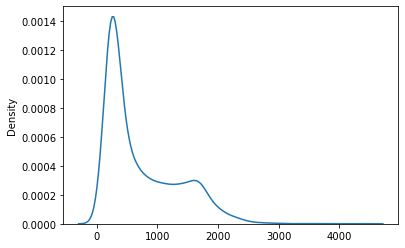

In [8]:
a = [len(row['xs']) for _, row in df.iterrows()]
sns.kdeplot(a)

In [ ]:
# for n in range(12):
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = Image.open("intersection2.png")
#     im = ImageOps.flip(im)
#     ax.set_xlim(0,1280)
#     ax.set_ylim(0,720)
#     ax.imshow(im, origin='lower')
    
#     mask = df['cluster'] == n
#     for _, row in df.loc[mask].iterrows():
#         ax.plot(row['xs'], row['ys'])
#         ax.set_title('cluster: ' + str(n))

In [9]:
l_df = pd.read_csv('bsc-3m/signals_dense.csv')

# begin wrangling the data to use euclidean distance and more

In [ ]:
def euc(x, y):
    v = np.vstack((x, y)).T
    distances = np.linalg.norm(v[:-1] - v[1:], axis=1)
    return distances

In [ ]:
def get_mid(n):
    return np.array([sum(n['x'])/2, sum(n['y'])/2])

In [ ]:
def d2l(x, y, mid):
    v = np.vstack((x, y)).T
    return np.linalg.norm(v - mid, axis=1)

In [ ]:
d = {
    'x' : [],
    'y' : [],
    'euc' : [],
    'd_light' : [],
    'light_color' : [],
    'frames' : [],
    'class' : [],
    'cluster' : [],
    'direction' : []
}

step_size = 1
for _, row in df.iterrows():
    rowx = np.array(row['xs'][::step_size])
    rowy = np.array(row['ys'][::step_size])
    frames = np.array(row['frames'][::step_size][:-1])
    l_mid = get_mid(l_xy[light_dict[row['cluster']]])
    
    d['x'].append(rowx[:-1])
    d['y'].append(rowy[:-1])
    d['light_color'].append(np.array([l_df.loc[f][light_dict[row['cluster']]] for f in frames]))
    d['d_light'].append(d2l(rowx[:-1], rowy[:-1], l_mid))
    d['euc'].append(euc(rowx, rowy))
    d['frames'].append(frames)
    d['class'].append(row['class'])
    d['cluster'].append(row['cluster'])
    d['direction'].append(direction_dict[row['cluster']])

pdf = pd.DataFrame(d)

In [ ]:
with open('formatted.pkl', 'wb') as f:
    pickle.dump(pdf, f)

In [ ]:
plt.hist(pdf['cluster'], bins=np.arange(12))

In [10]:
with open('formatted.pkl', 'rb') as f:
    pdf = pickle.load(f)

In [ ]:
d = {
    'index' : [],
    'x' : [],
    'y' : [],
    'd_t-1' : [],
    'd_t-2' : [],
    'd_t-3' : [],
    'd_light' : [],
    'l0' : [],
    'l1' : [],
    'l2' : [],
    'l3' : [],
    'dir_0' : [],
    'dir_1' : [],
    'dir_2' : [],
    'frame' : [],
    'cluster' : [],
    'class' : [],
    'target' : []
}

l_enc = OneHotEncoder(handle_unknown='ignore').fit(np.array([0,1,2,3]).reshape(-1,1))
d_enc = OneHotEncoder(handle_unknown='ignore').fit(np.array(['left', 'straight', 'right']).reshape(-1,1))


for index, row in pdf.iterrows():
    for i in range(3, len(row['x'])):
        d['index'].append(index)
        d['x'].append(row['x'][i])
        d['y'].append(row['y'][i])
        d['d_t-1'].append(row['euc'][i-1])
        d['d_t-2'].append(row['euc'][i-2])
        d['d_t-3'].append(row['euc'][i-3])
        d['d_light'].append(row['d_light'][i])
        d['frame'].append(row['frames'][i])
        d['cluster'].append(row['cluster'])
        d['class'].append(row['class'])
        d['target'].append(row['euc'][i])
        
        # light color one hot encoding
        encoding = l_enc.transform([[row['light_color'][i]]]).toarray()
        for n in range(4):
            d['l'+str(n)].append(encoding[0,n])
        
        # direction one hot encoding
        encoding = d_enc.transform([[row['direction']]]).toarray()
        for n in range(3):
            d['dir_' + str(n)].append(encoding[0,n])

nndf = pd.DataFrame(d)

In [ ]:
with open('nndf.pkl', 'wb') as f:
    pickle.dump(nndf, f)

In [ ]:
plt.bar(['l0', 'l1', 'l2', 'l3'], np.sum(nndf[['l0', 'l1', 'l2', 'l3']],axis=0))

In [ ]:
nndf

# Train Validate Test split

In [ ]:
cols = ['x', 'y', 'd_t-1', 'd_t-2', 'd_t-3', 'd_light', 'l0', 'l1', 'l2', 'l3', 'dir_0', 'dir_1', 'dir_2', 'target']
this = nndf[cols]
df_train, df_val = train_test_split(this, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=1)

In [ ]:
x_train, y_train = df_train[cols[:-1]].to_numpy(), df_train[cols[-1:]].to_numpy().reshape(-1)
x_val, y_val = df_val[cols[:-1]].to_numpy(), df_val[cols[-1:]].to_numpy().reshape(-1)
x_test, y_test = df_test[cols[:-1]].to_numpy(), df_test[cols[-1:]].to_numpy().reshape(-1)

# Train model

In [ ]:
clf = MLPRegressor(verbose=True).fit(x_train, y_train)

In [ ]:
clf.score(x_val, y_val)

In [ ]:
plt.hist(y_val, bins=np.arange(0,10,.2))

# Visualize

In [ ]:
def distance(x_0, y_0, x_1, y_1):
    return np.linalg.norm(
        np.array([x_0, y_0]) - np.array([x_1, y_1])
    )

In [ ]:
def trajectory(x_t, y_t, d_travel, traj):
    if not len(traj):
        return x_t, y_t
    d_to_traj = distance(x_t, y_t, traj[0,0], traj[0,1])
    if d_travel <= d_to_traj:
        v = (traj[0] - np.array([x_t, y_t])) / distance(x_t, y_t, traj[0,0], traj[0,1])
        x_t += v[0]*d_travel
        y_t += v[1]*d_travel
        return x_t, y_t
    return trajectory(traj[0,0], traj[0,1], (d_travel - d_to_traj), traj[1:])

In [ ]:
traj = np.vstack((pdf.iloc[0]['x'], pdf.iloc[0]['y'])).T
trajectory(traj[0,0], traj[0,1], 10, traj[1:])

In [ ]:

#plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')

traj = np.vstack((pdf.iloc[0]['x'], pdf.iloc[0]['y'])).T

txt = ax.text(20,20, '', fontsize=35, color='w')
ln = ax.plot(traj[:,0], traj[:,1])
sc = ax.scatter([], [])

def init():
    x_t, y_t = trajectory(traj[500,0], traj[500,1], 0, traj[501:])
    sc = ax.scatter([x_t], [y_t])
    return sc, 

def update(frame):
    #x_t, y_t = trajectory(traj[0,0], traj[0,1], 5*frame, traj[1+frame:])
    x_t, y_t = traj[500+frame]
    sc.set_offsets([[x_t, y_t]])
    txt.set(text=str(round(frame/30)))
    return sc,

ani = FuncAnimation(fig, update, frames=np.arange(0,30*20), interval=30,
                    init_func=init, blit=True)

plt.show()
ani.save('jeff.gif')

In [ ]:
scats = [ax.scatter([],[]) for i in range(20)]
lines = [ax.plot([],[]) for i in range(20)]
llns =  [ax.plot([],[]) for i in range(20)]

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')

row = pdf.iloc[208]
traj = np.vstack((row['x'], row['y'])).T

txt = ax.text(20,20, '', fontsize=35, color='w')
lln, = ax.plot([], [])
ln = ax.plot(traj[:,0], traj[:,1])
sc = ax.scatter([], [])

def init():
    x_t, y_t = traj[0]
    sc = ax.scatter([x_t], [y_t])
    
    a = l_xy[light_dict[row['cluster']]]
    lln.set_data(a['x'], a['y'])
    
    return sc, lln,

def update(i):
    lln.set_color(['red', 'orange', 'yellow', 'green'][row['light_color'][i]])
    
    #x_t, y_t = trajectory(traj[0,0], traj[0,1], 5*i, traj[1+i:])
    x_t, y_t = traj[i]
    sc.set_offsets([[x_t, y_t]])

    # txt.set(text=str(round(i/30)))
    txt.set(text=str(round(row['frames'][i] / 30)))
    return sc,

g = 10
ani = FuncAnimation(fig, update, frames=np.arange(0, len(row['x']), g), interval=30/g,
                    init_func=init, blit=True)

plt.show()
ani.save('jeff.gif')

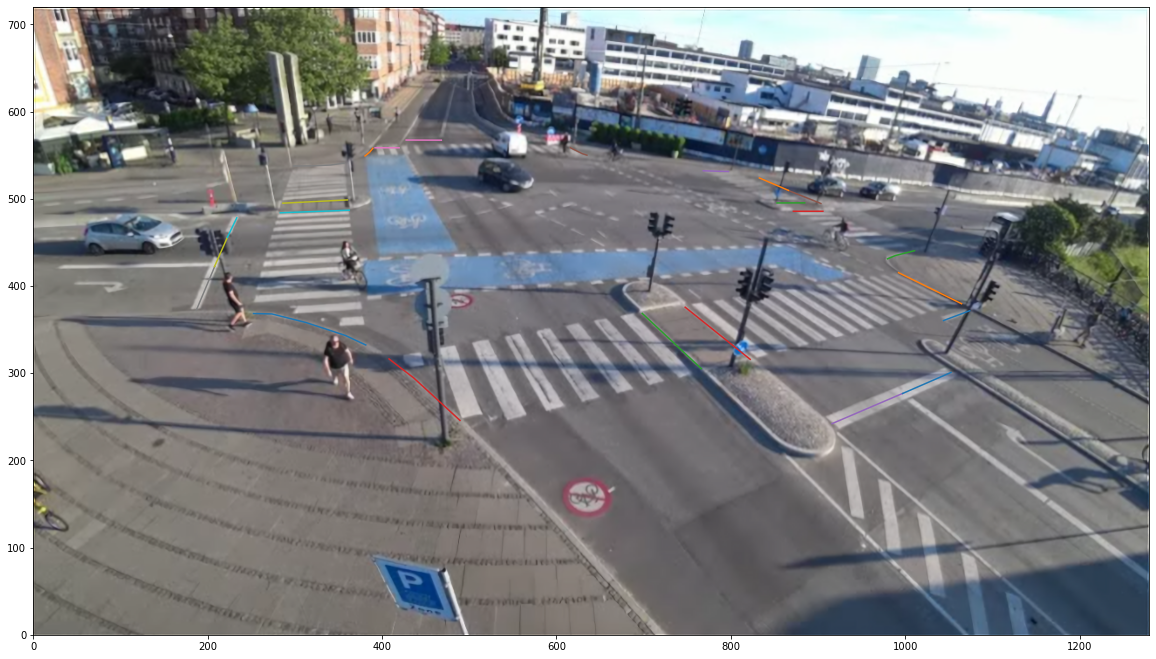

MovieWriter ffmpeg unavailable; using Pillow instead.


In [37]:
fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')

ln = [ax.plot([],[]) for _ in range(l_df.shape[-1]-1)]


def init():
    for i in range(len(l_xy)):
        ln[i][0].set_data(l_xy[i]['x'], l_xy[i]['y'])
    return ln[0][0], 

def update(frame):
    for n in range(l_df.shape[0]):
        for i in range(l_df.shape[1]-1):
            ln[i][0].set_color(['red', 'orange', 'yellow', 'green'][l_df.loc[n][1+i]])
    return ln[0][0],

g = 10
ani = FuncAnimation(fig, update, frames=np.arange(0, 10, g), interval=30/g,
                    init_func=init, blit=True)

plt.show()
ani.save('jeff2.gif')